In [36]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [37]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [38]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [39]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [40]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()


In [41]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [42]:
def DP(company, df):
  # Adding noise to dataset
  # calculating the variance of the mean_compound column
  news_column  = 'mean_compound'
  mc_var=np.var(df.mean_compound)
  mu=0
  noise=0.1
  sigma_noise = noise*mc_var
  n = df.shape[0]
  # create a dataframe for noise
  df_noise = pd.DataFrame()
  df_noise['mc_noise'] = df[news_column]
  for i in range(0,n):
      df_noise['mc_noise'][i]+=np.random.normal(mu,sigma_noise)  
  noise_name = "mc_noise_"+company+".csv"    
  df_noise.to_csv(noise_name)
  dfn = pd.read_csv(noise_name,index_col=0)
  # creating one dataframe by adding noise in news columns 
  df1 = pd.DataFrame()
  df1['price'] = df['adj_close']
  df1['mc'] = dfn['mc_noise']
  # creating another dataframe by adding normal noise column 
  df2 = pd.DataFrame()
  df2['price'] = df['adj_close']
  df2['mc'] = df['mean_compound']

  # choosing columns for the model
  cols = ['price','mc']
  # deciding the split size
  split = 0.85
  sequence_length=10;
  split_index = int(len(df1) * split)
  data_train1 = df1.get(cols).values[:split_index]
  data_train2 = df2.get(cols).values[:split_index]
  train_len  = len(data_train1)
  train_windows_len = None

  # Normalizing Train data1
  data_windows1 = create_windows(data_train1,train_len,sequence_length)
  normalized_data1,rmax_t1, rmin_t1 = Normalize_data(data_windows1)

  x_train1 = normalized_data1[:, :-1]
  y_train1 = normalized_data1[:, -1,[0]]

  # Normalizing Train data2
  data_windows2 = create_windows(data_train2, train_len,sequence_length)
  normalized_data2,rmax_t2, rmin_t2 = Normalize_data(data_windows2)

  x_train2 = normalized_data2[:, :-1]
  y_train2 = normalized_data2[:, -1,[0]]

  # concatenating the training data
  x_train = np.concatenate((x_train1,x_train2),axis=0)
  y_train = np.concatenate((y_train1,y_train2),axis=0)
  x_train.shape, y_train.shape

  #x_train = x_train1
  #y_train = y_train1

  # Creating the Test Data
  df_test = pd.read_csv(df_name, index_col = 0)
  df_test = df_test.rename(columns = {'adj_close': 'price','mean_compound':'mc'})
  #df_test['date'] = pd.to_datetime(df_test['date'])
  cols = ['price','mc']
  cols2 = ['date']
  test_len = df_test.shape[0]

  data_test  = df_test.get(cols).values[split_index:]
  data_test2  = df_test.get(cols2).values[split_index:]

  data_windows_test = create_windows(data_test, len(data_test), sequence_length)
  # the last price value of each window is the original y_test
  y_test_original = data_windows_test[:, -1, [0]]

  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  
  
  # Setting the parameters  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9

  # Simple RNN model
  model = Sequential()
  model.add(SimpleRNN(units = 60, activation = 'relu',return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 60,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 80, activation = 'relu',return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 120,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=10, batch_size=32)

  

  plot_training_loss(hist)
  #model_name = company+'_stock_predict_LSTM' 
  #model.save('saved_model/'+model_name)
  # Loading the model
  #model = tf.keras.models.load_model('saved_model/stock_predict_LSTM')

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  print(len(predicted_vals))
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)

  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")
  
  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [43]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
Epoch 1/10
92/92 [==============================] - 4s 13ms/step - loss: 0.2016 - mean_squared_error: 0.2016
Epoch 2/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0993 - mean_squared_error: 0.0993
Epoch 3/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0977 - mean_squared_error: 0.0977
Epoch 4/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0892 - mean_squared_error: 0.0892
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0884 - mean_squared_error: 0.0884
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0814 - mean_squared_error: 0.0814
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0796 - mean_squared_error: 0.0796
Epoch 8/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0793 - mean_squared_error: 0.0793
Epoch 9/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0799 - mean_squar

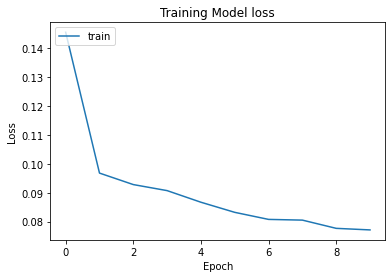

251
           date     Actual    Predicted
0    2019-01-30  37.715031    [38.1735]
1    2019-01-31  40.292267  [39.489388]
2    2019-02-01  40.582428   [39.62219]
3    2019-02-04  40.601936   [39.56441]
4    2019-02-05  41.755226  [40.751347]
..          ...        ...          ...
246  2020-01-22  78.347801   [77.81905]
247  2020-01-23  78.627464   [78.11061]
248  2020-01-24  79.006119  [78.505775]
249  2020-01-27  78.778435   [78.55897]
250  2020-01-28  76.461929   [77.24023]

[251 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

8/8 - 1s - loss: 0.0658 - mean_squared_error: 0.0658
LSTM Model Loss =  [0.06578367203474045, 0.06578367203474045]
Model Accuracy =  [98.69884]
Mean Absolute Error =  0.6838672835513417  degrees
Mean Squared Error =  0.6687728448352821
Root Mean Squared Error =  0.8177853293103772

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
Epoch 1/10
73/73 [==

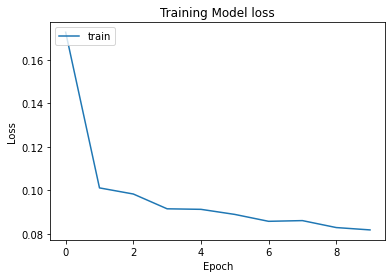

197
           date       Actual    Predicted
0    2019-04-12  1844.069946  [1836.8694]
1    2019-04-15  1843.060059  [1842.5568]
2    2019-04-17  1844.869995  [1842.5223]
3    2019-04-22  1864.819946  [1853.9384]
4    2019-04-23  1887.310059  [1873.2928]
..          ...          ...          ...
192  2020-01-30  1858.000000  [1856.0425]
193  2020-01-31  1870.680054  [1855.4657]
194  2020-02-03  2008.719971   [1951.284]
195  2020-02-04  2004.199951  [1925.4408]
196  2020-02-05  2049.669922  [1953.3142]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0747 - mean_squared_error: 0.0747
LSTM Model Loss =  [0.07474393397569656, 0.07474393397569656]
Model Accuracy =  [98.714096]
Mean Absolute Error =  23.62027891517291  degrees
Mean Squared Error =  983.7414866477859
Root Mean Squared Error =  31.364653459711395

--------------------------------------------------------------------------

Evaluating Model for Company:  AD

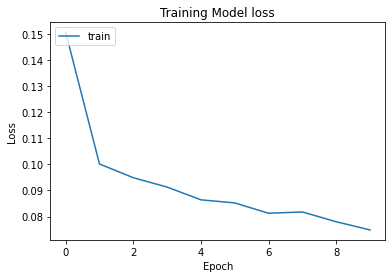

197
           date     Actual    Predicted
0    2019-04-12  40.507534  [39.835075]
1    2019-04-15  40.591747  [40.151543]
2    2019-04-17  40.554325   [40.33214]
3    2019-04-22  40.273605  [40.328033]
4    2019-04-23  39.918026   [40.39311]
..          ...        ...          ...
192  2020-01-30  41.956577  [42.809025]
193  2020-01-31  43.992935  [42.540134]
194  2020-02-03  42.993965  [42.575653]
195  2020-02-04  43.186077   [42.69846]
196  2020-02-05  43.579899  [42.907154]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0675 - mean_squared_error: 0.0675
LSTM Model Loss =  [0.06754667311906815, 0.06754667311906815]
Model Accuracy =  [98.752304]
Mean Absolute Error =  0.4897979310321326  degrees
Mean Squared Error =  0.35621168137181414
Root Mean Squared Error =  0.5968347186380951

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
Epoch 1/10
73/73 [

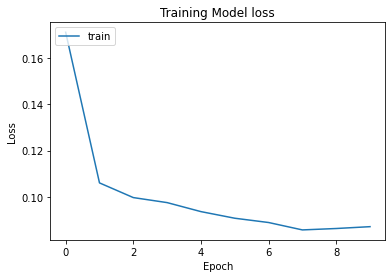

197
           date       Actual    Predicted
0    2019-04-12  1204.619995  [1206.4955]
1    2019-04-15  1217.869995  [1212.8112]
2    2019-04-17  1221.099976  [1213.9847]
3    2019-04-22  1236.339966  [1223.2649]
4    2019-04-23  1248.839966  [1229.3826]
..          ...          ...          ...
192  2020-01-30  1458.630005  [1472.7056]
193  2020-01-31  1455.839966  [1466.8087]
194  2020-02-03  1434.229980  [1452.7435]
195  2020-02-04  1485.939941  [1451.8213]
196  2020-02-05  1447.069946  [1451.4269]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0847 - mean_squared_error: 0.0847
LSTM Model Loss =  [0.08471763134002686, 0.08471763134002686]
Model Accuracy =  [98.65676]
Mean Absolute Error =  16.344439666283318  degrees
Mean Squared Error =  413.9610908755344
Root Mean Squared Error =  20.346033787338857

--------------------------------------------------------------------------

Evaluating Model for Company:  EB

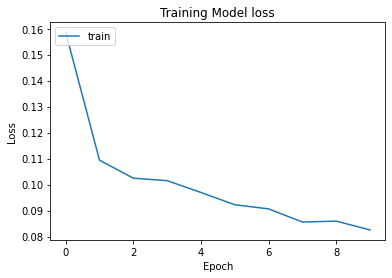

197
           date     Actual    Predicted
0    2019-04-12  35.292530   [36.08807]
1    2019-04-15  35.146770   [35.79126]
2    2019-04-17  35.205078  [35.746624]
3    2019-04-22  34.952431  [35.607304]
4    2019-04-23  35.127342   [35.61919]
..          ...        ...          ...
192  2020-01-30  33.982201   [34.71638]
193  2020-01-31  34.453903  [34.546906]
194  2020-02-03  32.979836    [33.8697]
195  2020-02-04  33.795483  [33.884026]
196  2020-02-05  36.763275  [34.444763]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0986 - mean_squared_error: 0.0986
LSTM Model Loss =  [0.09859927743673325, 0.09859927743673325]
Model Accuracy =  [98.646904]
Mean Absolute Error =  0.5004870225935419  degrees
Mean Squared Error =  0.3916886323683416
Root Mean Squared Error =  0.6258503274492565

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
Epoch 1/10
73/73 [==

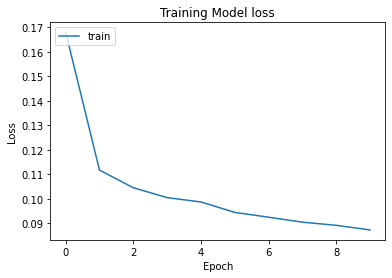

197
           date     Actual    Predicted
0    2019-04-12  72.001968   [72.39132]
1    2019-04-15  71.097000   [71.95823]
2    2019-04-17  70.859787   [71.96069]
3    2019-04-22  71.545097  [72.221085]
4    2019-04-23  72.836647  [71.693115]
..          ...        ...          ...
192  2020-01-30  58.377277  [59.573257]
193  2020-01-31  58.996475  [59.637337]
194  2020-02-03  56.565224  [58.223816]
195  2020-02-04  55.299515   [56.98776]
196  2020-02-05  54.607475  [56.319027]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0817 - mean_squared_error: 0.0817
LSTM Model Loss =  [0.08166097104549408, 0.08166097104549408]
Model Accuracy =  [98.77345]
Mean Absolute Error =  0.7877821752867727  degrees
Mean Squared Error =  0.9212589832268769
Root Mean Squared Error =  0.9598223706639041

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
Epoch 1/10
73/73 [===

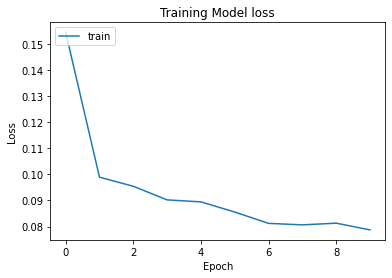

197
           date     Actual    Predicted
0    2019-04-12  76.076523   [76.47027]
1    2019-04-15  75.901398   [76.26557]
2    2019-04-17  75.405174   [75.89926]
3    2019-04-22  70.910042   [72.68333]
4    2019-04-23  72.495987   [72.64306]
..          ...        ...          ...
192  2020-01-30  87.775566   [89.57646]
193  2020-01-31  87.795273  [89.758896]
194  2020-02-03  85.806183   [88.89919]
195  2020-02-04  85.727409   [88.40359]
196  2020-02-05  86.879509  [87.093025]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0901 - mean_squared_error: 0.0901
LSTM Model Loss =  [0.09008412063121796, 0.09008412063121796]
Model Accuracy =  [98.87114]
Mean Absolute Error =  0.9149389509017092  degrees
Mean Squared Error =  1.3790532059688003
Root Mean Squared Error =  1.1743309610023915

--------------------------------------------------------------------------



In [44]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "CS_stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = DP(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)
  

In [48]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.683867,0.668773,[98.69884],0.817785
1,AMZN,23.620279,983.741487,[98.714096],31.364653
2,ADM,0.489798,0.356212,[98.752304],0.596835
3,GOOG,16.344440,413.961091,[98.65676],20.346034
4,EBAY,0.500487,0.391689,[98.646904],0.625850
5,XOM,0.787782,0.921259,[98.77345],0.959822
6,ABT,0.914939,1.379053,[98.87114],1.174331


In [49]:
# Mean Accuracy for DP-LSTM
mean_results = company_results.mean(axis = 0)
mean_results

MAE            6.19166
MSE            200.203
Accuracy    [98.73051]
RMSE           7.98362
dtype: object

In [47]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P21_RNN_company_specific_dplstm"+current_time+".csv"
company_results.to_csv(name)